<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/simple_ftt_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import plot_model

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
dataset_size = 1000
load_models = False # Loading previously saved model. Retraining models if false.
auto_scale = False # Whether or not to automatically scale the number of kernels to the number of outputs. If False, 2 convolutional kernels are used.

In [5]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_delme/'

In [6]:
def makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs):
  model = Sequential()
  #model.add(tf.keras.layers.experimental.preprocessing.Normalization()) # Comment out if no normalization of input data
  model.add(Conv1D(no_kernels, length_kernel, activation='relu', padding='same', input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(no_outputs, activation='linear'))
  return model

In [7]:
def plothistory(history):
  plt.figure(figsize=(16,10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.grid(which='both')
  plt.show()

In [8]:
def compile_and_train(X_train, y_train, filename, no_kernels=2,):
  length_kernel = 32
  no_outputs = y_train.shape[1]
  input_shape = (X_train.shape[1], X_train.shape[2]) # Only one trace per sample
  model = makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs)
  #plot_model(model, show_shapes=True, show_layer_names=True)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)
  plothistory(history)
  print(model.summary())
  model.save(filename)
  return model


In [9]:
def getmodel(X_train, y_train, filename, loadmodel=False, autoscale=True):
  if loadmodel:
    model = load_model(filename)
    print('Model loaded: ' + filename)
  else:
    if autoscale:
      no_kernels = y_train.shape[1]
    else:
      no_kernels = 2
    model = compile_and_train(X_train, y_train, filename, no_kernels=no_kernels)
    

  return model

In [10]:
def makecwsignal(amp, freq, phase, samplingfreq=128, t_end=1):
  # Returns CW cosine signal based on input parameters
  dt = 1/samplingfreq
  t_array = np.arange(0, t_end, dt)
  y = amp*np.cos(2*np.pi*freq*t_array + phase)
  return y

In [11]:
def makerandom(n, source_central_freq=10, source_mag = 1, seed=42):
  ''' Returns random frequencies around central frequency, random phase and 
  random amplitude. Random phase between 0 and pi.
  '''
  rng = np.random.default_rng(seed)
  randfreqs = source_central_freq*(0.5+rng.random(n))
  #randphases = 2*np.pi*rng.random(n) #if multiplied with 2, between 0 and 2pi
  randphases = rng.uniform(low=1, high=2*np.pi-1, size=n) #Phase between 1 and 5.28
  randamps = source_mag*(0.5+rng.random(n))
  d = {'Amplitude': randamps, 'Frequency': randfreqs, 'Phase': randphases}
  return pd.DataFrame(data=d)

In [12]:
def plot_hists(df):
  numplots = len(df.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(df.columns):
    plt.subplot(1,numplots, i+1)
    plt.hist(df[attribute])
    plt.title(attribute)

In [13]:
def preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  df_traces = pd.DataFrame(traces)
  plt.plot(traces[0])
  plt.plot(traces[1])
  plt.show()
  plt.figure(figsize=(18, 10))
  plt.pcolormesh(df_traces.T)
  plt.gca().invert_yaxis()
  plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(df_traces, df_iterations, test_size=0.2, random_state=42)
  X_train = np.expand_dims(X_train, axis=2)
  X_train.shape, y_train.shape
  return X_train, X_test, y_train, y_test

In [14]:
def test_and_predict(model, X_test, y_test):
  if X_test.ndim < 3:
    X_test = np.expand_dims(X_test, axis=2)
  performance = model.evaluate(X_test, y_test)
  y_predict = model(X_test)
  df_y_predict = pd.DataFrame(y_predict.numpy(), columns=y_test.columns)
  return df_y_predict, performance


In [15]:
def plotprediction(data_truth, data_prediction):
  numplots = len(data_prediction.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(data_prediction.columns):
    plt.subplot(1,numplots, i+1)
    plt.scatter(data_truth[attribute], data_prediction[attribute])
    plt.plot([min(data_truth[attribute]), max(data_truth[attribute])], [min(data_truth[attribute]), max(data_truth[attribute])], 'r--' )
    plt.title('Predicted vs true ' + attribute)
    plt.grid(which='both')
  plt.show()

In [16]:
def scale_features(df_iterations): 
  # Features min-max scaling
  scaler = MinMaxScaler()
  scaler.fit(df_iterations)
  df_iterations_norm = pd.DataFrame(scaler.transform(df_iterations), columns=df_iterations.columns)
  return df_iterations_norm, scaler

In [17]:
def inverse_scale_features(df_iterations_norm, scaler):
  return pd.DataFrame(scaler.inverse_transform(df_iterations_norm), columns=df_iterations_norm.columns)

In [18]:
#Amplitudes for CW2 always lower than for CW1
df_iterations_cw1 = makerandom(dataset_size, source_central_freq=10, source_mag=2, seed=11)
df_iterations_cw2 = makerandom(dataset_size, source_central_freq=10, source_mag=0.5, seed=22)
df_iterations_cw1.rename(columns={'Amplitude': 'Amplitude_1', 'Frequency': 'Frequency_1', 'Phase': 'Phase_1'}, inplace=True)
df_iterations_cw2.rename(columns={'Amplitude': 'Amplitude_2', 'Frequency': 'Frequency_2', 'Phase': 'Phase_2'}, inplace=True)


In [19]:
cw1 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw1['Amplitude_1'], df_iterations_cw1['Frequency_1'], df_iterations_cw1['Phase_1'])]
cw2 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw2['Amplitude_2'], df_iterations_cw2['Frequency_2'], df_iterations_cw2['Phase_2'])]


In [20]:
df_iterations_cw1_norm, scaler = scale_features(df_iterations_cw1)

In [78]:
def make_fft(traces):
  sample_rate = 128
  duration = 1
  n = sample_rate * duration
  traces_fft = rfft(traces, n=256)
  amps = np.abs(traces_fft)
  angles = np.angle(traces_fft)
  xf = rfftfreq(2*n, 1/sample_rate)
  return xf[0:-1], np.stack((traces, amps[:,0:-1], angles[:,0:-1]), axis=-1)

In [180]:
def train_and_test(traces, df_iterations, dataset_size=10000, no_kernels=2, length_kernel=32, use_trace=True, use_ampspect=True, use_phasespect=True):
  print(dataset_size)
  traces = traces[:dataset_size]
  df_iterations = df_iterations[:dataset_size]
  xf, traces_fft = make_fft(traces)
  if use_trace and not use_ampspect and not use_phasespect:
    traces_stacked = traces_fft[:,:,0]
    traces_stacked = np.expand_dims(traces_stacked, axis=-1)
  elif use_trace and use_ampspect and not use_phasespect:
    traces_stacked = traces_fft[:,:,0:2]
  elif use_trace and use_ampspect and use_phasespect:
    traces_stacked = traces_fft
  elif not use_trace and use_ampspect and not use_phasespect:
    traces_stacked = traces_fft[:,:,1]
    traces_stacked = np.expand_dims(traces_stacked, axis=-1)
  elif not use_trace and use_ampspect and use_phasespect:
    traces_stacked = traces_fft[:,:,1:3]
  else:
    print('error')
  
  df_iterations_norm, scaler = scale_features(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(traces_stacked, df_iterations_norm, test_size=0.2, random_state=42)
  print(X_train.shape)
  input_shape = X_train[0].shape
  print(input_shape)
  model = makecnnmodel(input_shape=input_shape, no_kernels=no_kernels, length_kernel=length_kernel, no_outputs=3)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=0, validation_split=0.2, shuffle=True)

  df_y_predict, performance = test_and_predict(model, X_test, y_test)

  y_test_unscaled = inverse_scale_features(y_test, scaler)
  df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler)
  plotprediction(y_test_unscaled, df_y_predict_unscaled)
  return pd.DataFrame([performance], columns=['loss', 'mse', 'mae'])

In [247]:
functionargs = list()

In [248]:

functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': False, 'use_ampspect': True, 'use_phasespect': True})

functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False})
functionargs.append({'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True})

In [249]:
functionargs[0]

{'dataset_size': 1000,
 'length_kernel': 32,
 'no_kernels': 2,
 'use_ampspect': False,
 'use_phasespect': False,
 'use_trace': True}

In [250]:
len(functionargs)

6

0
{'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False}
1000
(800, 128, 1)
(128, 1)
7/7 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0321


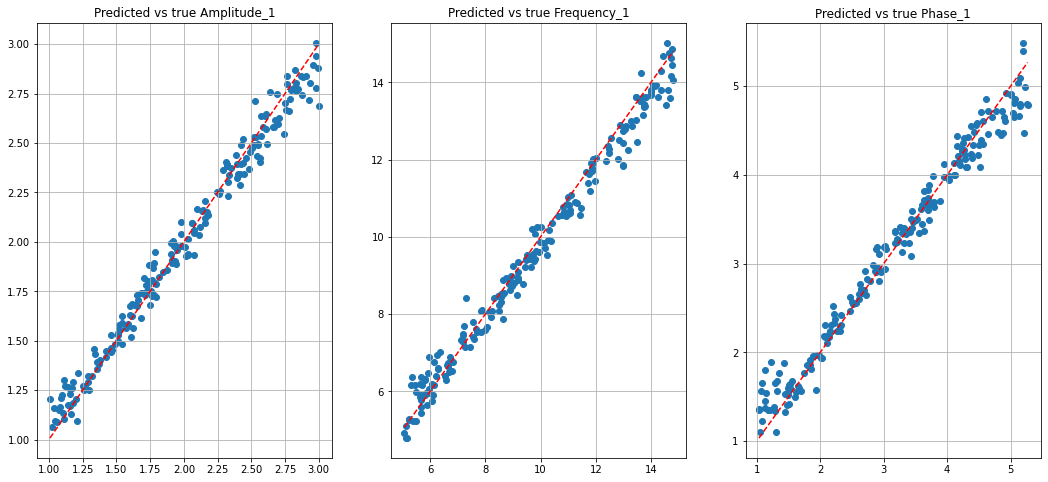

1
{'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False}
1000
(800, 128, 2)
(128, 2)
7/7 [==============================] - 0s 6ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0897


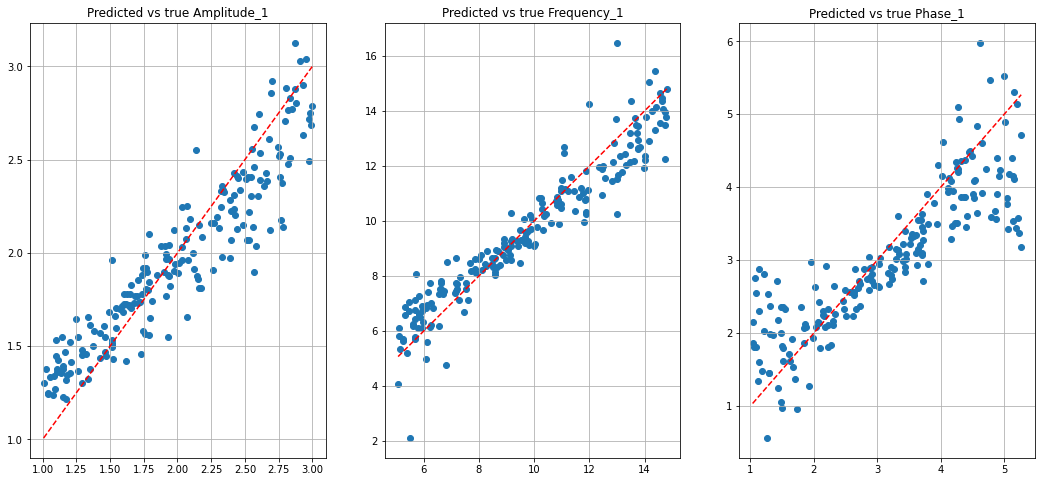

2
{'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 32, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True}
1000
(800, 128, 3)
(128, 3)
7/7 [==============================] - 0s 4ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0768


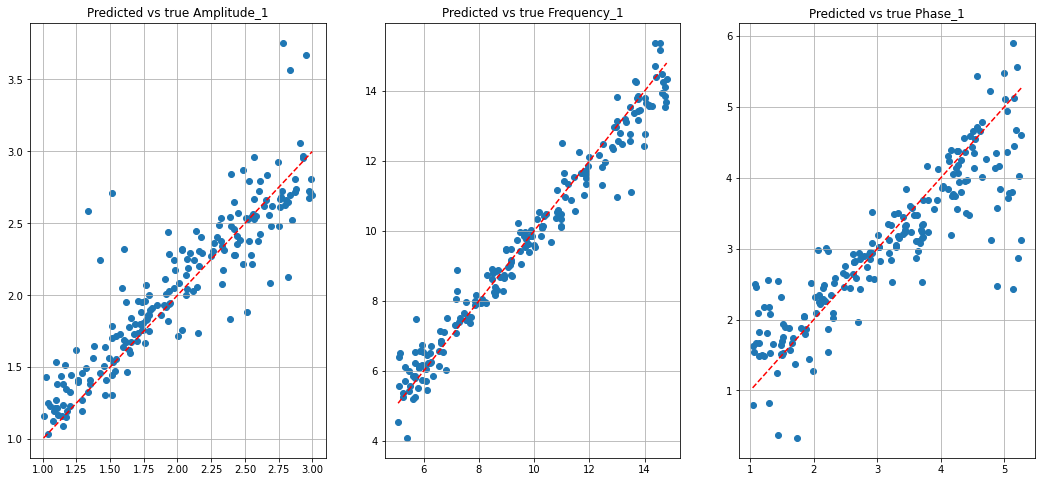

3
{'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': False, 'use_phasespect': False}
1000
(800, 128, 1)
(128, 1)
7/7 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0361


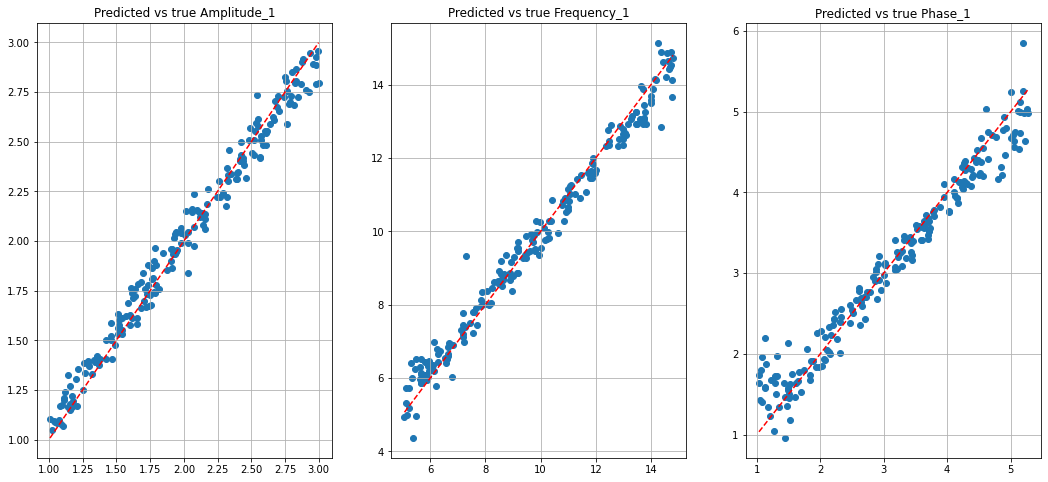

4
{'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': False}
1000
(800, 128, 2)
(128, 2)
7/7 [==============================] - 0s 3ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0830


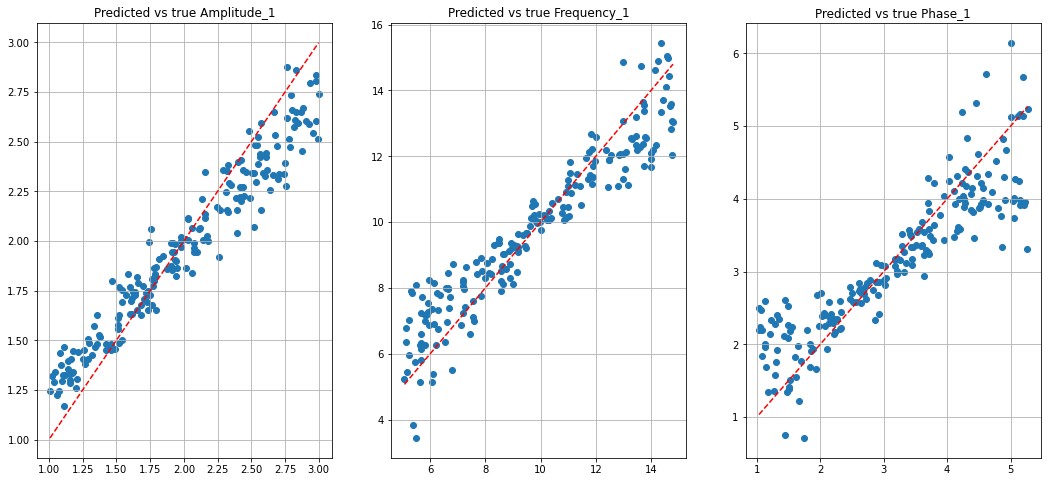

5
{'dataset_size': 1000, 'no_kernels': 2, 'length_kernel': 8, 'use_trace': True, 'use_ampspect': True, 'use_phasespect': True}
1000
(800, 128, 3)
(128, 3)
7/7 [==============================] - 0s 4ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0932


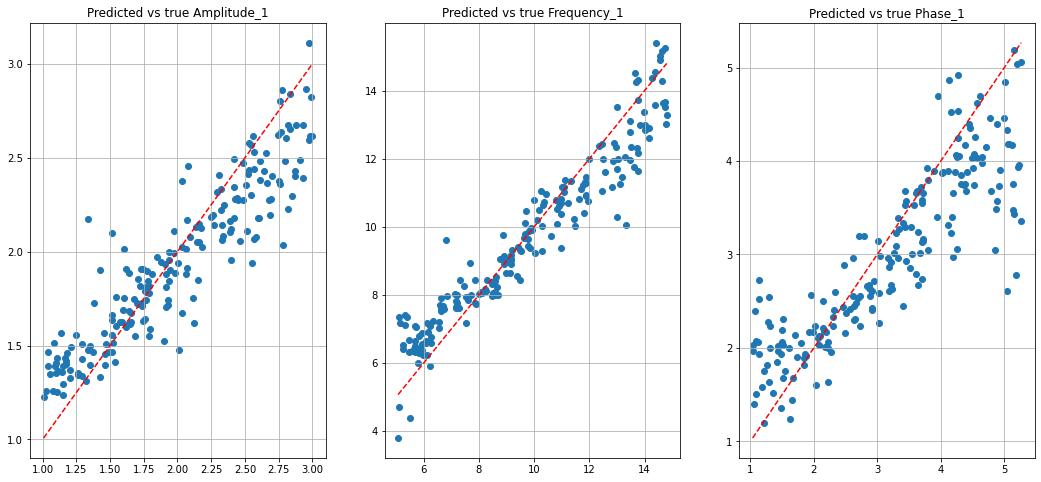

In [251]:
for i in range(len(functionargs)):
  print(i)
  print(functionargs[i])
  df_performance = train_and_test(cw1, df_iterations_cw1, **functionargs[i])
  if i==0:
    df_functionargs = pd.DataFrame.from_dict([functionargs[i]]).join(df_performance)
  else:
    df_functionargs = df_functionargs.append((pd.DataFrame.from_dict([functionargs[i]])).join(df_performance))

In [252]:
df_functionargs

,dataset_size,no_kernels,length_kernel,use_trace,use_ampspect,use_phasespect,loss,mse,mae
0,1000,2,32,True,False,False,0.001786,0.001786,0.032065
0,1000,2,32,True,True,False,0.014557,0.014557,0.089709
0,1000,2,32,True,True,True,0.013786,0.013786,0.076787
0,1000,2,8,True,False,False,0.002373,0.002373,0.036056
0,1000,2,8,True,True,False,0.012148,0.012148,0.082957
0,1000,2,8,True,True,True,0.015801,0.015801,0.093225


In [253]:
stop

NameError: ignored

In [192]:
df_functionargs = pd.DataFrame.from_dict([functionargs])

In [190]:
df_functionargs = df_functionargs.append(pd.DataFrame.from_dict([functionargs]))

NameError: ignored

In [193]:
df_functionargs

,dataset_size,no_kernels,length_kernel,use_trace,use_ampspect,use_phasespect
0,1000,2,32,True,False,False


1000
(800, 128, 1)
(128, 1)
7/7 [==============================] - 0s 4ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0283


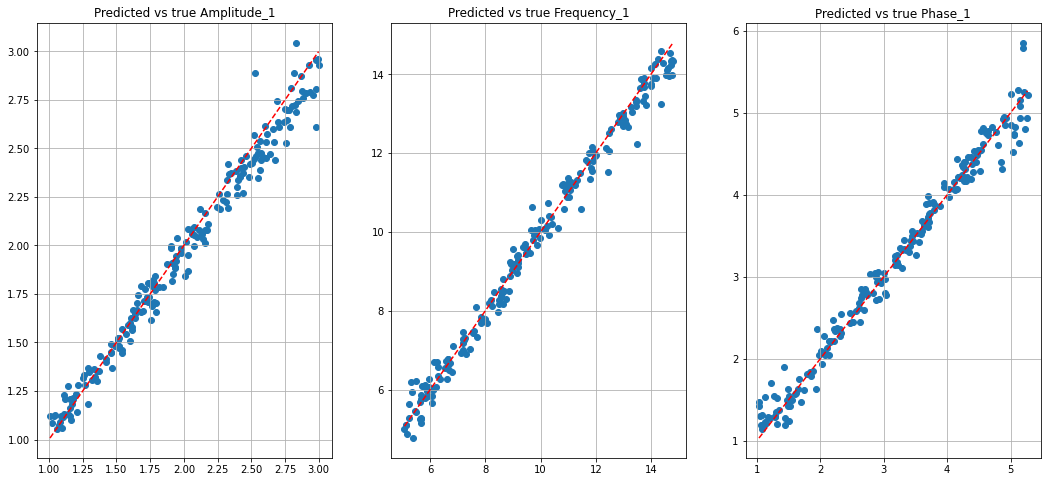

In [194]:
performance = train_and_test(cw1, df_iterations_cw1, **functionargs)

In [196]:
df_functionargs.join(performance)

,dataset_size,no_kernels,length_kernel,use_trace,use_ampspect,use_phasespect,loss,mse,mae
0,1000,2,32,True,False,False,0.001537,0.001537,0.028342


(800, 128, 2)
(128, 2)
7/7 [==============================] - 0s 4ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1187


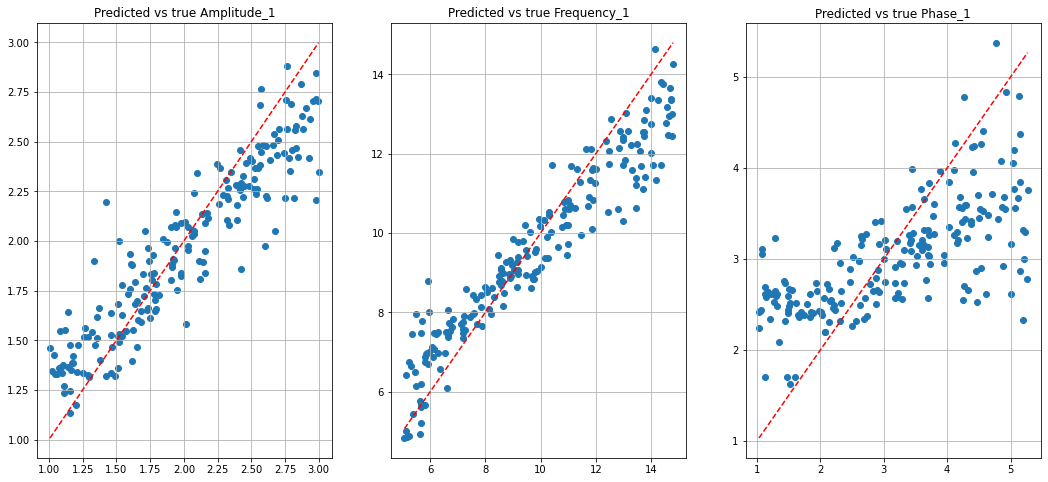

In [142]:
performance = train_and_test(cw1, df_iterations_cw1, dataset_size=1000, use_trace=False, use_ampspect=True, use_phasespect=True)
#traces_stacked.shape

In [136]:
performance

[0.0017603370361030102, 0.0017603370361030102, 0.031515151262283325]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(cw1, df_iterations_cw1_norm, test_size=0.2, random_state=42)

In [22]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [23]:
X_train[0].shape

(128, 1)

In [ ]:
model = makecnnmodel(input_shape=(128,1), no_kernels=2, length_kernel=16, no_outputs=3)
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)

7/7 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0330


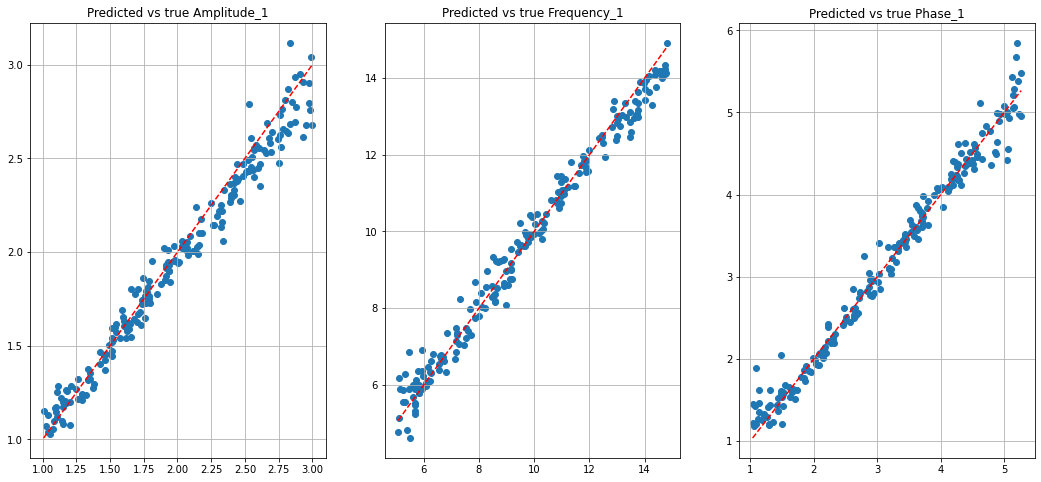

In [25]:
df_y_predict, performance = test_and_predict(model, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

# FFT

In [26]:
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq

In [75]:
np.stack(cw1, axis=-1)

array([[-0.24566669,  1.04581757,  0.92726867, ..., -1.37352081,
        -0.64663099, -1.08030952],
       [ 0.28857489, -0.04715861, -0.64428303, ...,  0.02247298,
         0.18615711, -2.02496597],
       [ 0.79556075, -1.12901369, -2.0320211 , ...,  1.40728585,
         0.93438961, -2.55001907],
       ...,
       [ 1.15634703,  2.11168334,  2.83331505, ...,  2.08673707,
        -0.67358618, -2.5079552 ],
       [ 1.49595759,  2.30243909,  2.84434632, ...,  1.75853378,
        -1.19601687, -2.57954328],
       [ 1.69427588,  1.95022587,  2.04388703, ...,  0.55541239,
        -1.17519721, -2.11661126]])

In [77]:
cw1.shape

AttributeError: ignored

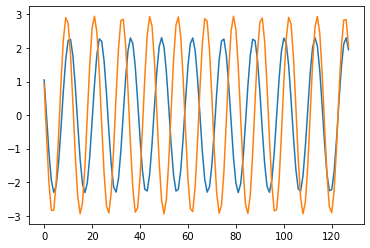

In [45]:
plt.plot(cw1[1])
plt.plot(cw1[2])
plt.show()

In [86]:
xf, cw1_fft = make_fft(cw1)

In [83]:
cw1_fft = cw1_fft[:,:,1:2]

In [87]:
cw1_fft.shape

(1000, 128, 3)

In [88]:
len(xf)

128

In [89]:
len(cw1_fft), cw1_fft[0].shape

(1000, (128, 3))

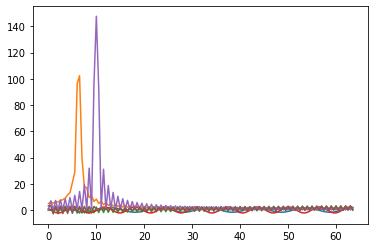

In [90]:
plt.plot(xf, cw1_fft[0])
plt.plot(xf, cw1_fft[1])
#plt.xlim((0, 20))
plt.show()

In [91]:
df_iterations_cw1

,Amplitude_1,Frequency_1,Phase_1
0,1.738489,6.285702,4.570604
1,2.308808,9.992779,1.100704
2,2.945902,11.014984,1.250587
3,2.539612,5.286890,3.490518
4,1.438499,6.479261,3.259555
...,...,...,...
995,2.336614,5.153435,1.477629
996,2.660007,12.579550,3.436871
997,2.106686,14.685298,4.002194
998,1.259637,14.003808,4.173308


In [92]:
X_train, X_test, y_train, y_test = train_test_split(cw1_fft, df_iterations_cw1_norm, test_size=0.2, random_state=42)

In [93]:
df_iterations_cw1_norm

,Amplitude_1,Frequency_1,Phase_1
0,0.369201,0.126838,0.834690
1,0.654558,0.498794,0.022971
2,0.973325,0.601358,0.058033
3,0.770039,0.026621,0.582024
4,0.219102,0.146259,0.527994
...,...,...,...
995,0.668470,0.013230,0.111146
996,0.830279,0.758342,0.569474
997,0.553427,0.969625,0.701721
998,0.129609,0.901247,0.741750


In [68]:
#X_train = np.expand_dims(X_train, axis=2)

In [94]:
input_shape = X_train.shape[1], X_train.shape[2]

In [95]:
input_shape

(128, 3)

In [96]:
model_fft = makecnnmodel(input_shape=input_shape, no_kernels=2, length_kernel=16, no_outputs=3)

In [97]:
model_fft.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [100]:
history = model_fft.fit(X_train, y_train, batch_size=20, epochs=100, verbose=0, validation_split=0.2, shuffle=True)

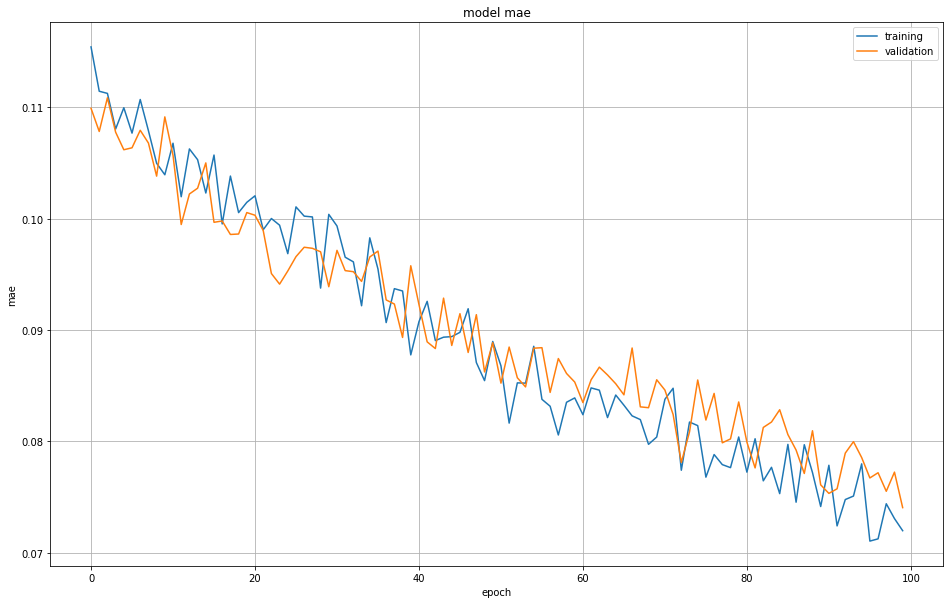

In [103]:
plothistory(history)

7/7 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0684


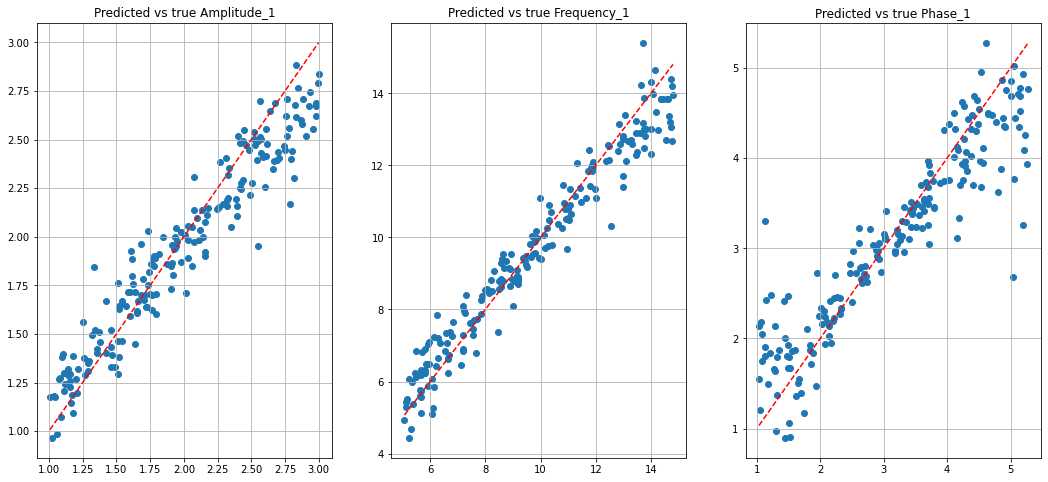

In [101]:
df_y_predict, performance = test_and_predict(model_fft, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler)
plotprediction(y_test_unscaled, df_y_predict_unscaled)